In [31]:
import torch
import torch as nn

# Importamos otras bibliotecas de utilidad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Manejo de ficheros
import os

# Ignoramos los warning
import warnings
warnings.filterwarnings("ignore")

# Importamos OpenCV
import cv2

In [32]:
# Comprobamos la version de PyTorch instalada
print(torch.__version__)

2.0.1


## Conjunto de datos 

Este conjunto de datos tiene su origen en el Instituto de Visión y Gráficos por Computadora de la Universidad Tecnológica de Graz

Obtenido de un reto de Kaggle (https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset/data). En este dataset vemos dos conjuntos de datos, uno para realizar segmentación binaria y otro para multiclase, este último es de nuestro interés.

Esta compuesto por 5 macrogrupos de clases {obstaculos, agua, naturaleza, en movimiento, aterrizable}

## Carga de datos

In [33]:
from tqdm import tqdm
import time

In [34]:
# Función para cargar y procesar las imágenes
def load_images(path, mask, dim, map_pixels):
    images = []

    # Recorremos todas las imágenes de la carpeta
    for filename in tqdm(os.listdir(path), desc="Procesando imágenes"):
        
        # Unicamente imágenes en formato png o jpg
        if filename.endswith(".png") or filename.endswith(".jpg"):
            
            # Obtener el número de imagen del nombre de archivo
            image_number = filename.split('.')[0]
            
            # Obtenemos la ruta a la imagen en concreto
            image_path = os.path.join(path, filename)
            
            # Si es máscara, obtenemos la imagen en escala de grises si no, en formato RGB
            if mask is True:
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                # Remapeamos los píxeles utilizando el diccionario 
                for key, value in map_pixels.items():
                     image[image == key] = value
            else:
                image = cv2.imread(image_path) 

            # redimensiona al tamaño elegido
            resized_image = cv2.resize(image, dim)

            # Agregar la imagen a la lista, con su número
            images.append((image_number, resized_image))
    
    # Ordenar la lista por número de imagen para que coincidan las máscaras y las imágenes originales
    images.sort(key=lambda x: int(x[0]))
    
    # Obtenemos únicamente las imágenes de la lista de tuplas, sin los índices
    return [image for (_, image) in images]

### Elegir dimensiones que han de tomar las imágenes de salida

In [35]:
# Utilizamos el diccionario de mapeo de clases para hacer que los pixeles tomen valores de 0 a 4, ya que tenemos 5 clases.

map_pixels = {
    0: 0, 6: 0, 5: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 21: 0, 22: 0, 23: 0,
    5: 1, 7: 1,
    2: 2, 3: 2, 8: 2, 19: 2, 20: 2,
    15: 3, 16: 3, 17: 3, 18: 3,
    1: 4, 4: 4, 9: 4
}

In [36]:
# Booleano que nos diferencia de tratar las mascaras en escala de grises o imagenes originales RGB
# Tamaño al que queremos redimensionar las mascaras e imagenes
is_mask = True
dim = (256,256)

In [37]:
# Rutas de las carpetas que contienen las imágenes

path_mask = "Dataset/semantic_drone_dataset/semantic_drone_dataset/label_images_semantic"
path_original_img = "Dataset/semantic_drone_dataset/semantic_drone_dataset/original_images"

# Medimos los tiempos para cargar las máscaras
t_ini = time.time()

# Cargar las imágenes de las etiquetas (máscaras) en escala de grises
label_images = load_images(path_mask, is_mask, dim, map_pixels)

t_fin = time.time()
print("\nEl tiempo de carga de las máscaras es de: ", t_fin-t_ini, " segundos")

# Cargar las imágenes originales en formato RGB
is_mask = False

t_ini = time.time()
original_images = load_images(path_original_img, is_mask, dim, map_pixels)
t_fin = time.time()

print("\nEl tiempo de carga de las imágenes es de: ", t_fin-t_ini, " segundos")

Procesando imágenes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:07<00:00,  3.71it/s]



El tiempo de carga de las máscaras es de:  7.015784740447998  segundos


Procesando imágenes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  3.22it/s]


El tiempo de carga de las imágenes es de:  8.07400894165039  segundos


In [38]:
# Para encontrar el valor máximo de las máscaras y comprobamos que es 4, ya que tenemos 5 clases.
# Si el pixel vale:
# 0 --> obstaculo
# 1 --> agua
# 2 --> naturaleza (vegetacion)
# 3 --> objetos en movimiento
# 4 --> zonas aterrizables

max(np.max(mask) for mask in label_images)

4

#### Como podemos observar el tiempo de carga de las imágenes RBG ligeramente superior que el de las máscaras, en escala de grises. Podriamos pensar que deberia ser el triple debido a que las imágenes RBG presentan 3 canales de información y las máscaras tan solo 1. Aunque es cierto que esto ocurre, en nuestro caso necesitamos realizar un mapeo del valores de los píxeles, este mapeo realentiza el doble el tiempo de carga de las máscaras.

In [39]:
# Ahora, label_images contiene imágenes en escala de grises 
# y original_images contiene imágenes en formato RGB.

# Accedemos a la quinta imagen como ejemplo
label_image = label_images[5]
original_image = original_images[5]

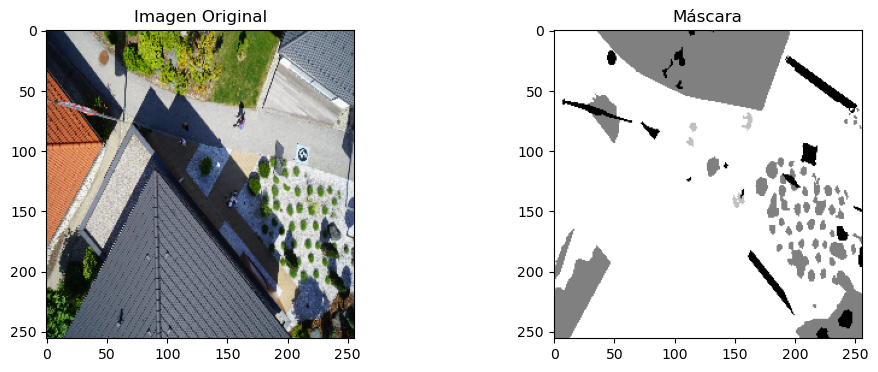

In [40]:
# Aqui realizo una impresión de la máscara en escala de grises y de la imagen original, tomando como ejemplo la imagen 0 el conjunto
# Mostrar la imagen de la máscara (escala de grises)
plt.figure(figsize=(12, 4)) 

# Mostrar la imagen original (RGB)
plt.subplot(121)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original")

plt.subplot(122)
plt.imshow(label_image, cmap='gray')
plt.title("Máscara")

plt.show()

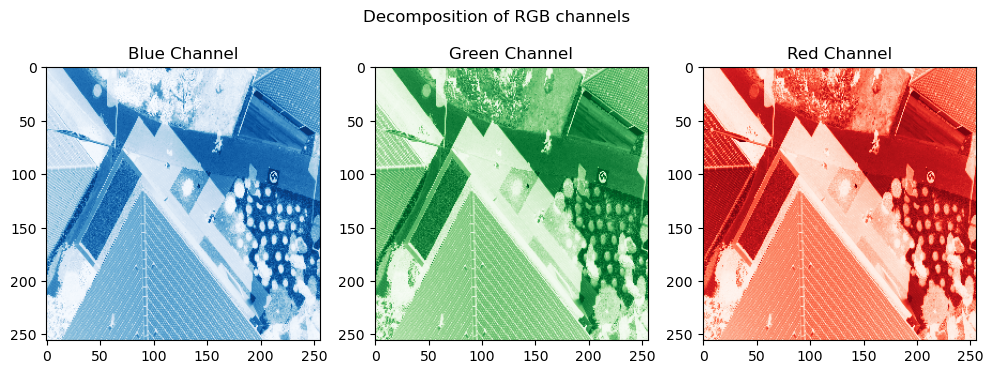

In [41]:
# Extraemos de original_image, las 3 matrices, una por cada canal de informacion

channel_blue = original_image[:,:,0] # blue
channel_green = original_image[:,:,1] # green
channel_red = original_image[:,:,2] # red

# Representamos cada una de ellas
plt.figure(figsize=(12, 4))  # Tamaño de la figura

plt.subplot(131)
plt.imshow(channel_blue, cmap='Blues')
plt.title("Blue Channel")

plt.subplot(132)
plt.imshow(channel_green, cmap='Greens')
plt.title("Green Channel")

plt.subplot(133)
plt.imshow(channel_red, cmap='Reds')
plt.title("Red Channel")

plt.suptitle("Decomposition of RGB channels")  # Título general
plt.show()

## Preprocesamiento de las imágenes

#### Como el conjunto de datos del que disponemos es pequeño vamos a aplicar técnicas de Data Augmentation, para conseguir aumentar la diversidad de las muestras de entrenamiento.

## Técnicas de Data Augmentation

##### Con el fin de aumentar el número de imágenes del conjunto de entrenamiento para el modelo, vamos a realizar transfromaciones como reflejos, rotaciones, cambios de brillo y zoom en este conjunto. Así conseguimos tener más imágenes y aumentar la capacidad de generalización del modelo

In [42]:
import torchvision.transforms as transforms
from torchvision.utils import save_image

# Rotaciones
from scipy.ndimage import rotate

### Efecto espejo

In [43]:
# Conseguimos proporcionar variabilidad en las imágenes y aumentar el tamaño del conjunto de entrenamiento

def mirror_effect(imgs, masks):
    for i in range(len(imgs)):
        imgs.append(np.fliplr(imgs[i]))
        masks.append(np.fliplr(masks[i]))

In [44]:
mirror_effect(original_images, label_images)
len(original_images), len(label_images)

(52, 52)

#### Tras la primera transformación, duplicamos el número de imágenes --> pasamos de tener 400 imagenes y 400 máscaras a 800 de cada una de ellas

### Variabilidad de la imagen

In [45]:
def variability_effect(brillo, contraste, saturacion, imagenes, is_mask):
    
    imagenes_modif = []

    # Usar tqdm para mostrar una barra de progreso
    for imagen_original in imagenes:
        if is_mask:
            # Ajustar el brillo y contraste en la máscara
            imagen_ajst = cv2.convertScaleAbs(imagen_original, alpha=contraste, beta=brillo)
        else:
            # Ajustar el brillo y contraste
            imagen_ajst = cv2.convertScaleAbs(imagen_original, alpha=contraste, beta=brillo)

            # Convertir la imagen a formato HSV
            imagen_hsv = cv2.cvtColor(imagen_ajst, cv2.COLOR_RGB2HSV)

            # Ajustar la saturación
            imagen_hsv[:, :, 1] = imagen_hsv[:, :, 1] * saturacion

            # Convertir la imagen de nuevo a formato RGB
            imagen_ajst = cv2.cvtColor(imagen_hsv, cv2.COLOR_HSV2RGB)

        # Agregar la imagen modificada a la lista de imágenes modificadas
        imagenes_modif.append(imagen_ajst)

    return imagenes_modif


In [46]:
# Parámetros a modificar:
# --> Brillo
# --> Contraste
# --> Saturación

brillo = 1.7
contraste = 1.5
saturacion = 1.7

# Modificamos las imagenes
var_images = variability_effect(brillo, contraste, saturacion, original_images, is_mask)

# Modificamos las máscaras
is_mask = True
var_masks = variability_effect(brillo, contraste, saturacion, label_images, is_mask)

# Las añadimos a los conjuntos de imagenes correspondientes
original_images.extend(var_images)
label_images.extend(var_masks)

In [47]:
len(original_images), len(label_images)

(104, 104)

#### Nuevamente duplicamos el número de imágenes y máscaras del conjunto, pasamos de tener 800 en cada una de ellas a 1600.

In [48]:
def rotation_effect(angulos, imagenes, is_mask):
    imagenes_rotadas = []
    
    # Para cada imagen
    for imagen in tqdm(imagenes, desc="Rotando tus imágenes"):
        # Vamos a obtener 7 imágenes por cada una de ellas, puesto que las rotamos de 45º en 45º
        for angulo in angulos:
            
            # La opción reflect, nos completa las esquinas que quedarian en negro tras la rotación
            if is_mask is True:
                # Order=0 para vecino más cercano, y así evitar que se modifiquen ciertos valores de píxeles
                imagen_rotada = rotate(imagen, angulo, reshape=False, mode='constant', cval=0, order=0) 
                imagenes_rotadas.append(imagen_rotada)
            else:
                # Iteracion entre los canales de la imagen
                canales_rotados = [rotate(channel, angulo, reshape=False, mode='reflect') for channel in np.rollaxis(imagen, 2)]
                imagen_rotada = np.stack(canales_rotados, axis=-1)
                imagenes_rotadas.append(imagen_rotada)
            
    return imagenes_rotadas

In [49]:
rotaciones = [45, 90, 135, 180, 225, 270, 315]

# Rotaciones para las imagenes RGB
is_mask = False
rot_images = rotation_effect(rotaciones, original_images, is_mask)

# Rotaciones para las máscaras
is_mask = True
rot_masks = rotation_effect(rotaciones, label_images, is_mask)

Rotando tus imágenes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:01<00:00, 84.17it/s]


In [50]:
# Las añadimos a los conjuntos de imagenes correspondientes
original_images.extend(rot_images)
label_images.extend(rot_masks)

In [51]:
len(original_images), len(label_images)

(832, 832)

#### Tras aplicar 7 rotaciones en ángulos diferentes para cada una de las imágenes y máscaras del conjunto de datos anterior, multiplicando por 7 el tamaño del conjunto. De esta forma conseguimos tener 12800 imágenes, y dotamos al modelo de un mayor conjunto de datos para poder aprender y generalizar.

## Mostramos las imágenes RGB modificadas

In [57]:
# Creo un array en el cual accedo por indice a una misma imagen, en mi caso la primera, y sus modificaciones
img_rgb = [original_images[0], original_images[400], original_images[800], original_images[1200], rot_images[0],rot_images[1],rot_images[2],rot_images[3],
          rot_images[4],rot_images[5], rot_images[6]]

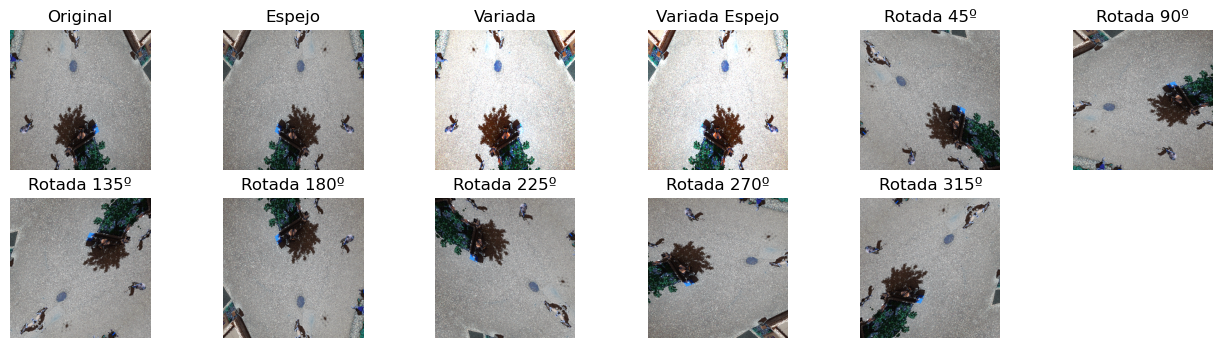

In [58]:
# Generamos una "cuadricula" de 2 filas y 6 columnas por fila
fig, axes = plt.subplots(2, 6, figsize=(16, 4))

j = 0

for i in range(len(img_rgb)):
        
    row = i // 6  # Calcular la fila actual
    col = i % 6   # Calcular la columna actual
    
    axes[row, col].imshow(img_rgb[i])
    axes[row, col].axis('off')
    
    if i == 0:
        axes[row, col].set_title("Original")
    elif i == 1:
        axes[row, col].set_title("Espejo")
    elif i == 2:
        axes[row, col].set_title("Variada")
    elif i == 3:
        axes[row, col].set_title("Variada Espejo")
    else:
        j += 1
        axes[row, col].set_title(f"Rotada {45 * j}º")

# Eliminamos la ultima casilla, para evitar que nos genere ejes vacios
fig.delaxes(axes[1, 5])
plt.show()

### Aunque no se haya mostrado, a su vez cada imagen espejo, variada y variada espejo, presenta tambien sus 7 rotaciones en los diferentes ángulos. Considero importante mencionarlo de ahí que se obtengan 12000 imágenes pero únicamente muestro las rotaciones de la imagen original, para evitar complicaciones

## Mostramos las máscaras modificadas

In [59]:
# Creo un array en el cual accedo por indice a una misma imagen, en mi caso la primera, y sus modificaciones
mask_grey = [label_images[0], label_images[400], label_images[800], label_images[1200], rot_masks[0],rot_masks[1],rot_masks[2],rot_masks[3],
          rot_masks[4],rot_masks[5], rot_masks[6]]

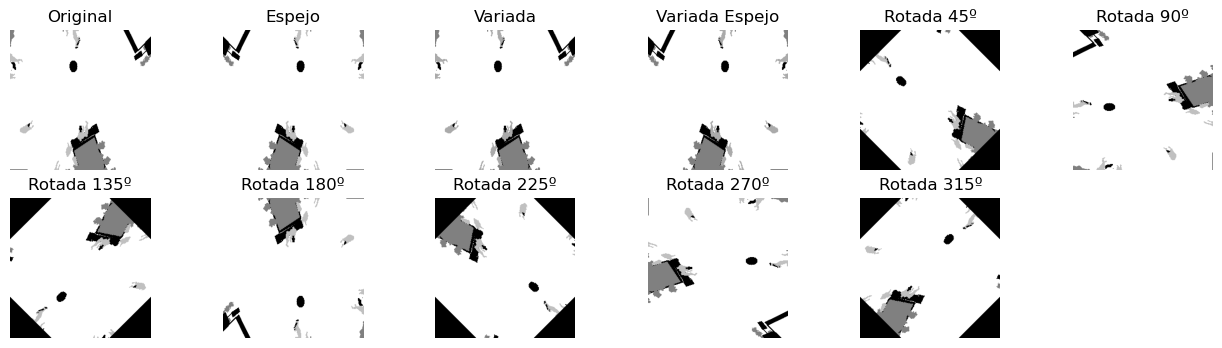

In [60]:
# Mismo procedimiento
fig, axes = plt.subplots(2, 6, figsize=(16, 4))

j = 0

for i in range(len(mask_grey)):
        
    row = i // 6  # Calcular la fila actual
    col = i % 6   # Calcular la columna actual
    
    axes[row, col].imshow(mask_grey[i], cmap="gray")
    axes[row, col].axis('off')
    
    if i == 0:
        axes[row, col].set_title("Original")
    elif i == 1:
        axes[row, col].set_title("Espejo")
    elif i == 2:
        axes[row, col].set_title("Variada")
    elif i == 3:
        axes[row, col].set_title("Variada Espejo")
    else:
        j += 1
        axes[row, col].set_title(f"Rotada {45 * j}º")

# Eliminamos la ultima casilla, para evitar que nos genere ejes vacios
fig.delaxes(axes[1, 5])
plt.show()

## Conjunto de entrenamiento y prueba

##### Para separar las imágenes de train y test, vamos a randomizar con una semilla el orden de las imágenes y las máscaras. Así conseguimos que al aplicar un hold-out para separar generar cada conjunto, las imágenes que van a cada conjunto sean random, y no por orden de aparición en el conjunto.

In [61]:
# Imports correspondientes

# Separación entre entrenamiento y test
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from multiprocessing import Pool

In [62]:
# Medimos los tiempos para convertir las máscaras
t_ini = time.time()

# Convertimos la tupla de mascaras a tensores
label_images = torch.Tensor(label_images)

t_fin = time.time()
print("\nEl tiempo de convertir las máscaras de numpy a tensor es de: ", t_fin-t_ini, " segundos")
print("El tensor de las máscaras tiene tamaño: ", label_images.shape)


El tiempo de convertir las máscaras de numpy a tensor es de:  4.6240997314453125  segundos
El tensor de las máscaras tiene tamaño:  torch.Size([832, 256, 256])


In [63]:
# Medimos los tiempos para convertir las máscaras
t_ini = time.time()

# Convertimos la tupla de mascaras a tensores
original_images = torch.Tensor(original_images)

t_fin = time.time()

print("\nEl tiempo de convertir las imágenes de numpy a tensor es de: ", t_fin-t_ini, " segundos")
print("El tensor de las imágenes tiene tamaño: ", original_images.shape)


El tiempo de convertir las imágenes de numpy a tensor es de:  56.39678382873535  segundos
El tensor de las imágenes tiene tamaño:  torch.Size([832, 256, 256, 3])


In [64]:
# Generamos los conjuntos de train y test, para imagenes y máscaras usando el 20% para test y el 80% para train

img_train, img_test, labels_train, labels_test = train_test_split(original_images, label_images, test_size=0.2, random_state=42)

In [65]:
# Generamos los datasets de train y test

train_dataset = TensorDataset(img_train, labels_train)
test_dataset = TensorDataset(img_test, labels_test)

# Debido al hold-out aplicado ahora tenemos 320 imagenes para test y 1280 para train

print("\nTamaño del conjunto de train: ", len(train_dataset))
print("\nTamaño del conjunto de test: ", len(test_dataset))


Tamaño del conjunto de train:  665

Tamaño del conjunto de test:  167


In [66]:
# Empleamos lotes de 6 imágenes

batch_size = 6

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [67]:
# Despues de hacer lotes de 6 imágenes

print("\nHay ", len(train_dataloader), " lotes de 6 imágenes, formando asi las 1280 imágenes totales usadas para train")
print("\nHay ", len(test_dataloader), " lotes de 6 imágenes, formando asi las 320 imágenes totales usadas para train")


Hay  111  lotes de 6 imágenes, formando asi las 1280 imágenes totales usadas para train

Hay  28  lotes de 6 imágenes, formando asi las 320 imágenes totales usadas para train


In [71]:
# Comprobamos que sigue habiendo correspondencia entre las imágenes y máscaras en cada conjunto y que han sido aleatorizadas

label_train,image_train,label_test,image_test = labels_train[220],img_train[220],labels_test[220],img_test[220]

IndexError: index 220 is out of bounds for dimension 0 with size 167

In [72]:
# Para poder representar las imagenes correspondientes, necesito convertir los tensores a array de nuevo.
image_train = image_train / 255.0
image_test = image_test / 255.0

image_train = image_train.numpy()
label_train = label_train.numpy()
image_test = image_test.numpy()
label_test = label_test.numpy()

NameError: name 'image_train' is not defined

NameError: name 'image_train' is not defined

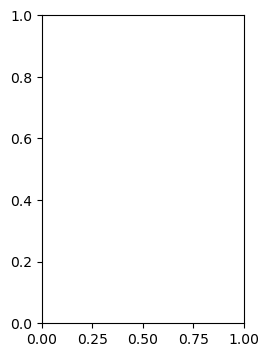

In [73]:
plt.figure(figsize=(12, 4)) 

# Mostrar la imagen original (RGB)
plt.subplot(141)
plt.imshow(cv2.cvtColor(image_train, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original Train")

plt.subplot(142)
plt.imshow(label_train, cmap='gray')
plt.title("Máscara Train")

plt.subplot(143)
plt.imshow(cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original Test")

plt.subplot(144)
plt.imshow(label_test, cmap='gray')
plt.title("Máscara Test")

plt.show()

## Normalización ???

## Creación del modelo

In [74]:
# Runneamos en este .ipynb el notebook que contiene la clase del modelo UNet que queremos crear
%run Model/unet.ipynb

In [75]:
# Nº clases de salida son 5 los objetos a identificar: agua, vegetacion, obstaculo, movimiento y zona aterrizable
out_classes = 5

# Elección técnica de upsampling
# "conv_transpose" --> convolución transpuesta
# "bilinear" --> interpolación bilineal
# "maxunpooling" --> max unpooling

upsample_tec = "bilinear"

# U-NET Model build
unet_model = UNet(out_classes,upsample_tec)

In [76]:
# Comprobamos si nos identifica una GPU --> si la hay lo asignamos a la variable "device"

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device,"\n")

# Pasamos el modelo a la GPU, si disponemos de ella
unet_model #.to(device)

cpu 



UNet(
  (down_1): DownsamplingBlock(
    (blockConv): BlockConv(
      (blockConv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_2): DownsamplingBlock(
    (blockConv): BlockConv(
      (blockConv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_3): DownsamplingBlock(
    (blockConv): BlockConv(
      (blockConv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(

## Entrenamiento

In [77]:
# Paquete de optimizadores
import torch.optim as optim

from sklearn.metrics import accuracy_score

### Función que lleva a cabo el entrenamiento del modelo. Tiene 5 parámetros, el primero que recibe el modelo creado a partir de su clase, train_dataloader que es el conjunto de entrenamiento, optm representa el optimizador que emplea el modelo, loss_criterion función de pérdida que emplea el entrenamiento y por último, device que contiene la gpu en caso de haberla.

In [78]:
def train_unet(model, train_dataloader, optm, loss_criterion, device):
    
    # Modo de entrenamiento del modelo
    model.train()
    running_loss = 0.0
    
    # Para cada imagen y mascara del conjunto
    for images, masks in train_dataloader:
        
        # Vemos el tamaño del tensor para cada imagen [6,128,128,3] y no coincide con la entrada esperada por el modelo por lo que rotamos
        #print(images.size())
        
        # Transpone las dimensiones para que los canales estén en la posición correcta, con respecto al modelo [6,3,128,128]
        images = images.permute(0, 3, 1, 2)  

        # Convertimos a long el tensor de las máscaras
        masks = masks.to(torch.long)
        
        #inputs, masks = inputs.to(device), masks.to(device)  # Mueve los datos a la GPU si está disponible
        
        # Limpia los gradientes del optimizador
        optm.zero_grad()
        
        # Realiza la inferencia
        outputs = model(images)
        
        # Calcula la pérdida
        loss = loss_criterion(outputs, masks)
        
        # Realiza la retropropagación y actualiza los pesos del modelo
        loss.backward()
        optm.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader)

In [79]:
# Definimos parámetros
epochs = 10   # Nº épocas
stop = 10     # Nº iteraciones sin mejora para que pare
ite = 0       # Contador de iteraciones

# Función de perdida
floss = 0

# Optimizador
optm = optim.Adam(unet_model.parameters(), lr=0.001)


# Función de pérdida
# floss = 0 --> Entropía cruzada
# floss = 1 --> Error cuadratico medio
if floss == 0:
    loss_crit = nn.CrossEntropyLoss()
elif floss == 1:
    loss_crit = nn.MSELoss()
    
for epoch in range(epochs):
    train_loss = train_unet(unet_model, train_dataloader, optm, loss_crit, device)
    print(f"Época {epoch + 1}, Pérdida de entrenamiento: {train_loss:.4f}")

IndexError: Target 5 is out of bounds.